## Plot Gradient of Electron Density on a Plane
Assumes you have python 2, numpy, chemtools and matplotlib installed.

The process is as follows:

1. Compute a grid on the affine plane spanned by the molecular coordiantes.
2. Compute the gradient of the electron density on each point of the plane.
3. Project the gradient so that it lies on the plane.
4. Rotate the plane, the gradients so that it lies on the x-y axis.
5. Plot them in 2D.

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Need this to plot in 3D

from chemtools.wrappers.molecule import Molecule

# Construct Molecule object to calculate the electron density and gradient
mol = Molecule.from_file("./data/h2o.fchk")

print("Molecular Coordinates:")
print(mol.coordinates)
print("Molecular Charge:")
print(mol.numbers)

Initialized: <horton.gbasis.cext.GOBasis object at 0x7fa40cc14c20>
  Number of basis functions         : 41
  Number of normalization constants : 65
  Maximum shell type                : 2
  Center     0 :  S7 S7 S1 S1 P3 P1 P1 Dp1 Dp1
  Center     1 :  S3 S1 S1 P1 P1
  Center     2 :  S3 S1 S1 P1 P1

Molecular Coordinates:
[[ 0.01594845  0.01700428  0.023858  ]
 [-0.77277844  0.56144655  1.57501231]
 [ 1.29850109  1.26951236 -0.30911333]]
Molecular Charge:
[8 1 1]


Water is a planar molecule, and so the coordinates should be lying on an affine plane.

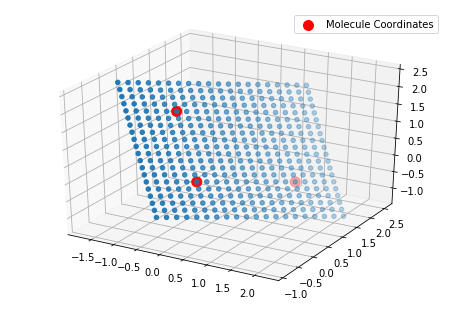

In [8]:
coord = mol.coordinates
# Construct the two vectors that lie on the plane.
a, b = coord[1] - coord[0], coord[2] - coord[0]

# Step-size
ss = 0.1
num_pts = 20
origin = coord[0] - 0.5 * a - 0.5 * b  # Origin to start the grid.
c = np.arange(0, num_pts)
c = np.array(np.meshgrid(c, c)).T.reshape(-1,2)

# Construct a grid on the affine plane:
grid = []
# First, construct a grid on the plane spanned by a and b.
for (i, j) in c:
    grid.append(ss * (a * i + b * j))
grid = np.array(grid)
# Translate the plane to the affine plane containing the molecule's coordinates
grid += origin

# Plot the grid and molecular coordinates.
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(grid[:, 0], grid[:, 1], grid[:, 2])
ax.scatter(coord[:, 0], coord[:, 1], coord[:, 2], c="r", s=100,
           label="Molecule Coordinates")
plt.legend()
plt.show()

The gradient points to the direction of greatest increase of the electron density.


Here, I'll compute the gradient at each of the affine points and plot them in three-dimensions.
It's kinda hard to see, but the some of these gradient vectors aren't on the affine plane.

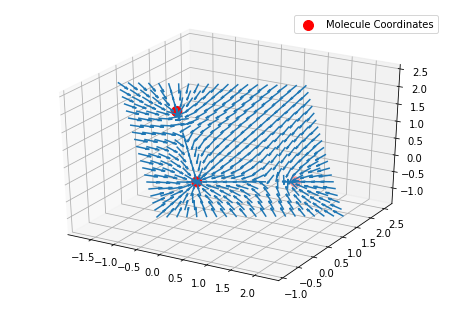

In [9]:
# Compute the gradient at each of the points in the afffine plane
gradients = mol.compute_gradient(grid)
# Plot the Three-dimensional vector field.
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(coord[:, 0], coord[:, 1], coord[:, 2], c="r", s=100,
           label="Molecule Coordinates")
ax.quiver(grid[:, 0],grid[:, 1], grid[:, 2],
          gradients[:, 0], gradients[:, 1], gradients[:, 2], length=0.25,
          normalize=True)
plt.legend()
plt.show()

Here, I'll project the gradient on the plane.
https://www.maplesoft.com/support/help/maple/view.aspx?path=MathApps%2FProjectionOfVectorOntoPlane

In [10]:
# Calculate normal vector to the plane
#    The normal vector is a vector of norm 1, that is orthogonal to every vector of the plane.
normal = np.cross(a, b)
normal /= np.linalg.norm(normal)

# Project gradient onto the plane
proj_gradients = gradients - np.dot(gradients, normal)[:, np.newaxis] * normal
# Make sure it is on the plane by making sure it is orthogonal to the normal.
assert np.all(np.dot(proj_gradients, normal) < 1e-5)

Rotate the plane to lie on the x-y axis, then plot it as a 2D vector field.
See https://math.stackexchange.com/questions/1167717/transform-a-plane-to-the-xy-plane

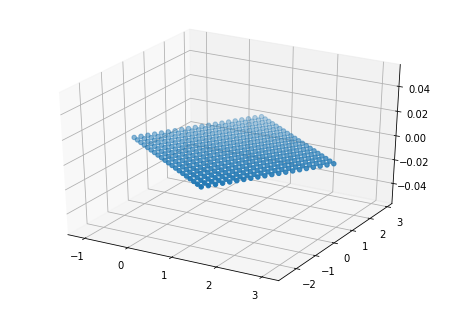

In [11]:
a, b, c = normal
cos_theta = c
sin_theta = np.sqrt(a**2.0 + b**2.0)
u_1 = b / np.sqrt(a**2.0 + b**2.0)
u_2 = -a / np.sqrt(a**2.0 + b**2.0)
rot = np.array([
    [cos_theta + u_1**2.0 * (1 - cos_theta), u_1 * u_2 * (1 - cos_theta), u_2 * sin_theta],
    [u_1 * u_2 * (1 - cos_theta), cos_theta + u_2**2.0 * (1 - cos_theta), -u_1 * sin_theta],
    [-u_2 * sin_theta, u_1 * sin_theta, cos_theta]
])

# Rotate the plane onto x-y axis
grid_2d = np.dot(rot, (grid - coord[0]).T).T
assert np.all(np.abs(grid_2d[:, 2]) < 1e-8)  # Make sure the z-axis is zero.
grid_2d[:, 2] = 0.

# Rotate the projected gradients
rot_proj_gradients = np.dot(rot, proj_gradients.T).T

# Rotate the molecular coordinates
rot_coords = np.dot(rot, (coord - coord[0]).T).T

# Plot the rotated grid and molecular coordinates.
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(grid_2d[:, 0], grid_2d[:, 1], grid_2d[:, 2])
plt.show()

Finally, plot the vector field with normalized gradients

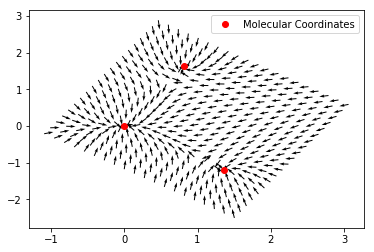

In [12]:
# Rotate Projected Plane.
rot_proj_gradients /= np.linalg.norm(rot_proj_gradients, axis=1).reshape((-1, 1))
plt.quiver(grid_2d[:, 0], grid_2d[:, 1],
         rot_proj_gradients[:, 0], rot_proj_gradients[:, 1])
plt.plot(rot_coords[:, 0], rot_coords[:, 1], "ro", label="Molecular Coordinates")
plt.legend()
plt.show()